In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
data = pd.read_csv('./data_scrap/data_2021_2022.csv')

In [2]:
# function with the help of chatGPT

def scrollable_dataframe(df):
    # Konwertuj DataFrame na tabelę HTML
    table_html = df.to_html(classes='table table-striped table-bordered table-hover',
                            table_id='scrollable_table', 
                            escape=False)

    # Tworzenie kodu HTML dla scrollowanej tabeli
    html = f'''
    <div style="width: 100%; height:400px; overflow:scroll;">
            <style>
             td, th {{
                white-space: nowrap;
                width: 100px;
                padding: 10px;
            }}
        </style>
        {table_html}
    </div>
    '''

    return html

In [3]:
from IPython.display import display, HTML
display(HTML(scrollable_dataframe(data)))

,possession_1st,possession_2nd,shots_1st,shots_2nd,shots_on_target_1st,shots_on_target_2nd,corners_1st,corners_2nd,passes_1st,passes_2nd,accurate_passes_1st,accurate_passes_2nd,crosses_1st,crosses_2nd,accurate_crosses_1st,accurate_crosses_2nd,successful_tackles_1st,successful_tackles_2nd,fouls_1st,fouls_2nd,offsides_1st,offsides_2nd,yellow_cards_1st,yellow_cards_2nd,red_cards_1st,red_cards_2nd,team_1st,team_2nd,score_1st,score_2nd
0,47.0,53.0,10.0,14.0,2.0,4.0,4.0,5.0,389.0,447.0,321.0,374.0,25.0,24.0,8.0,2.0,9.0,10.0,20.0,12.0,0.0,2.0,4.0,3.0,0.0,0.0,GÓRNIK ŁĘCZNA,JAGIELLONIA BIAŁYSTOK,0,1
1,51.0,49.0,20.0,12.0,8.0,6.0,9.0,2.0,447.0,452.0,376.0,373.0,26.0,9.0,6.0,2.0,7.0,12.0,7.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0,ŚLĄSK WROCŁAW,GÓRNIK ZABRZE,3,4
2,56.0,44.0,21.0,15.0,9.0,6.0,4.0,7.0,457.0,353.0,372.0,257.0,17.0,19.0,6.0,8.0,5.0,8.0,9.0,13.0,0.0,2.0,1.0,2.0,0.0,0.0,LECH POZNAŃ,KGHM ZAGŁĘBIE LUBIN,2,1
3,51.0,49.0,14.0,10.0,3.0,2.0,7.0,3.0,445.0,434.0,364.0,372.0,27.0,10.0,6.0,1.0,12.0,11.0,10.0,20.0,1.0,2.0,1.0,2.0,0.0,0.0,PIAST GLIWICE,RADOMIAK RADOM,1,1
4,54.0,46.0,18.0,4.0,5.0,2.0,7.0,3.0,411.0,368.0,333.0,287.0,28.0,5.0,11.0,0.0,4.0,11.0,19.0,11.0,0.0,1.0,2.0,2.0,0.0,0.0,WISŁA KRAKÓW,WARTA POZNAŃ,0,1
5,54.0,46.0,21.0,13.0,6.0,4.0,8.0,8.0,445.0,374.0,359.0,298.0,22.0,18.0,8.0,4.0,14.0,8.0,10.0,10.0,1.0,2.0,2.0,3.0,0.0,0.0,POGOŃ SZCZECIN,BRUK-BET TERMALICA NIECIECZA,2,2
6,49.0,51.0,18.0,7.0,9.0,3.0,6.0,1.0,426.0,448.0,332.0,349.0,14.0,8.0,3.0,1.0,10.0,5.0,14.0,16.0,3.0,0.0,1.0,4.0,0.0,0.0,RAKÓW CZĘSTOCHOWA,LECHIA GDAŃSK,3,0
7,51.0,49.0,12.0,15.0,4.0,2.0,4.0,7.0,432.0,408.0,347.0,330.0,16.0,20.0,8.0,6.0,13.0,11.0,16.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,LEGIA WARSZAWA,CRACOVIA,3,0
8,56.0,44.0,18.0,14.0,10.0,2.0,11.0,3.0,429.0,340.0,345.0,269.0,27.0,14.0,6.0,1.0,8.0,12.0,10.0,13.0,2.0,0.0,3.0,1.0,0.0,0.0,WISŁA PŁOCK,PGE FKS STAL MIELEC,3,0
9,54.0,46.0,27.0,5.0,6.0,0.0,7.0,5.0,423.0,370.0,351.0,285.0,26.0,17.0,6.0,3.0,16.0,9.0,11.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,CRACOVIA,WISŁA PŁOCK,3,0


In [4]:
from IPython.display import display, HTML
display(HTML(scrollable_dataframe(data.head(10))))

,possession_1st,possession_2nd,shots_1st,shots_2nd,shots_on_target_1st,shots_on_target_2nd,corners_1st,corners_2nd,passes_1st,passes_2nd,accurate_passes_1st,accurate_passes_2nd,crosses_1st,crosses_2nd,accurate_crosses_1st,accurate_crosses_2nd,successful_tackles_1st,successful_tackles_2nd,fouls_1st,fouls_2nd,offsides_1st,offsides_2nd,yellow_cards_1st,yellow_cards_2nd,red_cards_1st,red_cards_2nd,team_1st,team_2nd,score_1st,score_2nd
0,47.0,53.0,10.0,14.0,2.0,4.0,4.0,5.0,389.0,447.0,321.0,374.0,25.0,24.0,8.0,2.0,9.0,10.0,20.0,12.0,0.0,2.0,4.0,3.0,0.0,0.0,GÓRNIK ŁĘCZNA,JAGIELLONIA BIAŁYSTOK,0,1
1,51.0,49.0,20.0,12.0,8.0,6.0,9.0,2.0,447.0,452.0,376.0,373.0,26.0,9.0,6.0,2.0,7.0,12.0,7.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0,ŚLĄSK WROCŁAW,GÓRNIK ZABRZE,3,4
2,56.0,44.0,21.0,15.0,9.0,6.0,4.0,7.0,457.0,353.0,372.0,257.0,17.0,19.0,6.0,8.0,5.0,8.0,9.0,13.0,0.0,2.0,1.0,2.0,0.0,0.0,LECH POZNAŃ,KGHM ZAGŁĘBIE LUBIN,2,1
3,51.0,49.0,14.0,10.0,3.0,2.0,7.0,3.0,445.0,434.0,364.0,372.0,27.0,10.0,6.0,1.0,12.0,11.0,10.0,20.0,1.0,2.0,1.0,2.0,0.0,0.0,PIAST GLIWICE,RADOMIAK RADOM,1,1
4,54.0,46.0,18.0,4.0,5.0,2.0,7.0,3.0,411.0,368.0,333.0,287.0,28.0,5.0,11.0,0.0,4.0,11.0,19.0,11.0,0.0,1.0,2.0,2.0,0.0,0.0,WISŁA KRAKÓW,WARTA POZNAŃ,0,1
5,54.0,46.0,21.0,13.0,6.0,4.0,8.0,8.0,445.0,374.0,359.0,298.0,22.0,18.0,8.0,4.0,14.0,8.0,10.0,10.0,1.0,2.0,2.0,3.0,0.0,0.0,POGOŃ SZCZECIN,BRUK-BET TERMALICA NIECIECZA,2,2
6,49.0,51.0,18.0,7.0,9.0,3.0,6.0,1.0,426.0,448.0,332.0,349.0,14.0,8.0,3.0,1.0,10.0,5.0,14.0,16.0,3.0,0.0,1.0,4.0,0.0,0.0,RAKÓW CZĘSTOCHOWA,LECHIA GDAŃSK,3,0
7,51.0,49.0,12.0,15.0,4.0,2.0,4.0,7.0,432.0,408.0,347.0,330.0,16.0,20.0,8.0,6.0,13.0,11.0,16.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,LEGIA WARSZAWA,CRACOVIA,3,0
8,56.0,44.0,18.0,14.0,10.0,2.0,11.0,3.0,429.0,340.0,345.0,269.0,27.0,14.0,6.0,1.0,8.0,12.0,10.0,13.0,2.0,0.0,3.0,1.0,0.0,0.0,WISŁA PŁOCK,PGE FKS STAL MIELEC,3,0
9,54.0,46.0,27.0,5.0,6.0,0.0,7.0,5.0,423.0,370.0,351.0,285.0,26.0,17.0,6.0,3.0,16.0,9.0,11.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,CRACOVIA,WISŁA PŁOCK,3,0


In [5]:
len(data)

306

In [6]:
data.isna().sum()

possession_1st             75
possession_2nd             75
shots_1st                  75
shots_2nd                  75
shots_on_target_1st        75
shots_on_target_2nd        75
corners_1st                75
corners_2nd                75
passes_1st                 75
passes_2nd                 75
accurate_passes_1st        75
accurate_passes_2nd        75
crosses_1st               216
crosses_2nd               216
accurate_crosses_1st      216
accurate_crosses_2nd      216
successful_tackles_1st     75
successful_tackles_2nd     75
fouls_1st                  75
fouls_2nd                  75
offsides_1st               75
offsides_2nd               75
yellow_cards_1st           75
yellow_cards_2nd           75
red_cards_1st              75
red_cards_2nd              75
team_1st                    0
team_2nd                    0
score_1st                   0
score_2nd                   0
dtype: int64

### If 75 matches lack most of the data about match we still have more than 200 matches with most of the statistics (apart from crosses and successfull_tackles which are somehow not present in most of the matches)

In [7]:
numeric_cols = data.columns.to_list()
numeric_cols.remove('team_1st')
numeric_cols.remove('team_2nd')


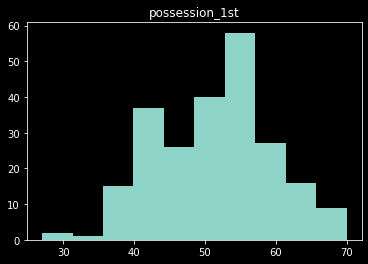

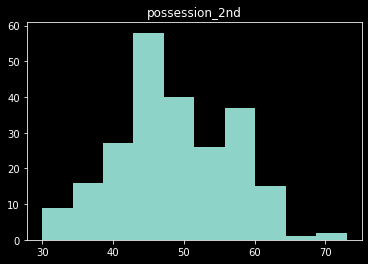

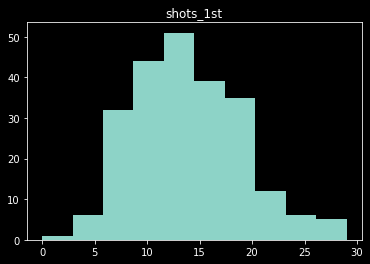

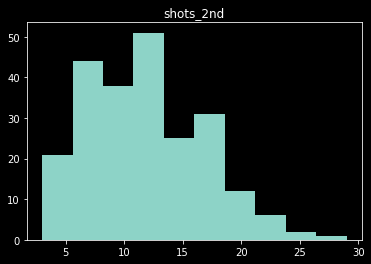

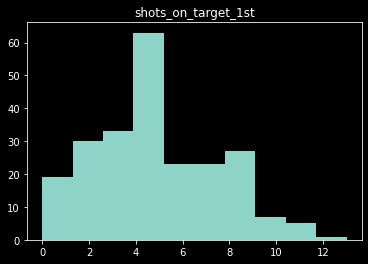

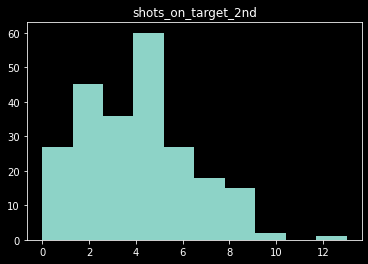

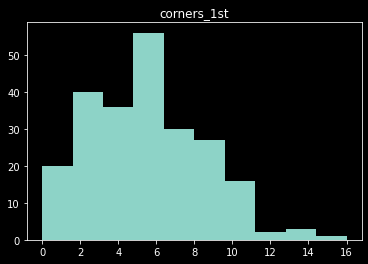

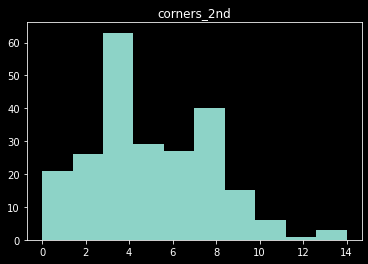

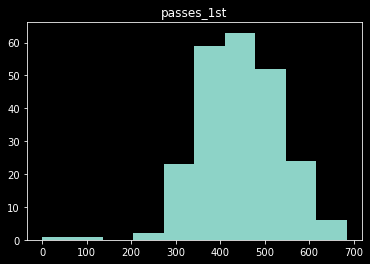

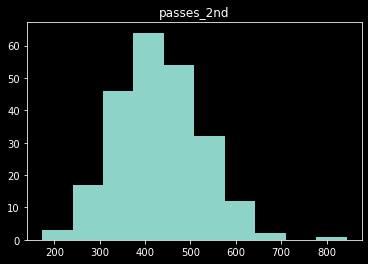

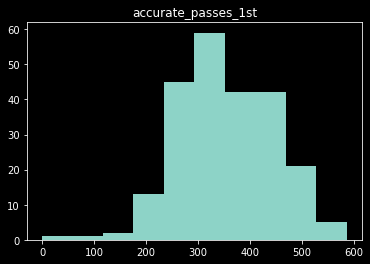

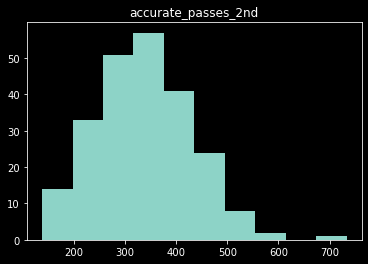

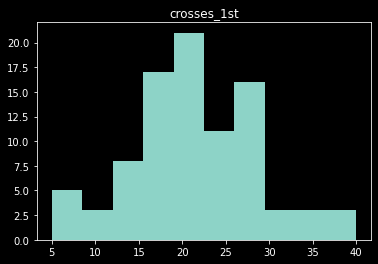

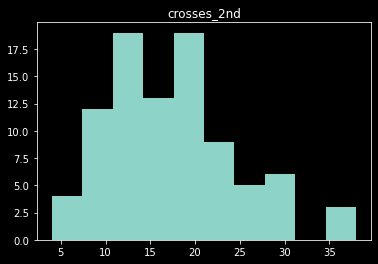

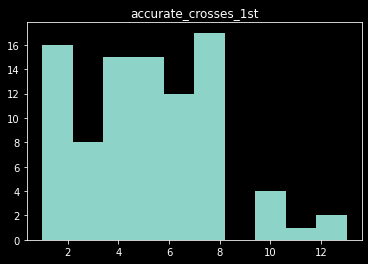

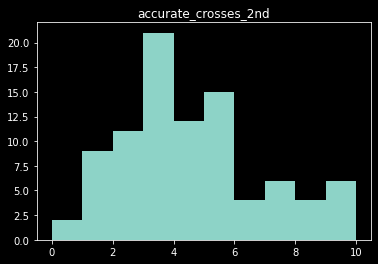

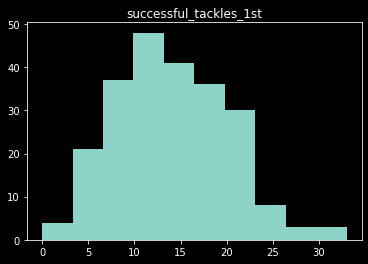

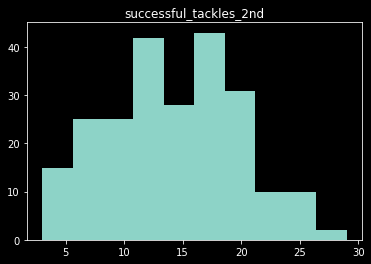

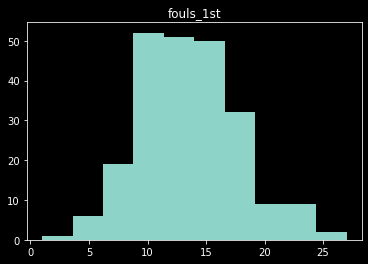

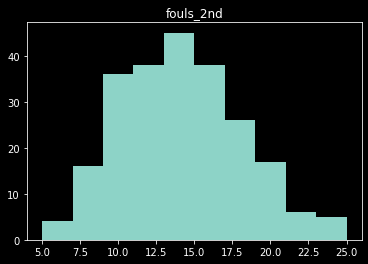

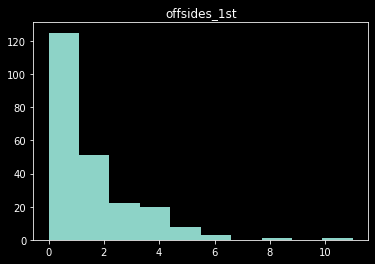

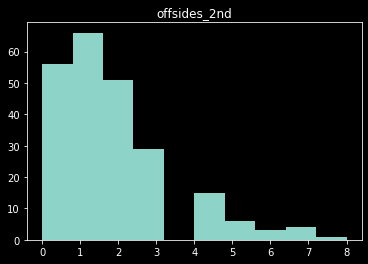

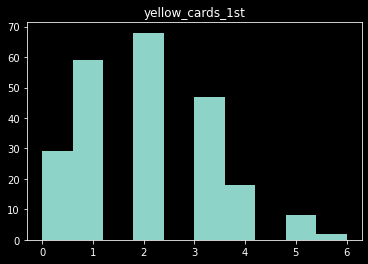

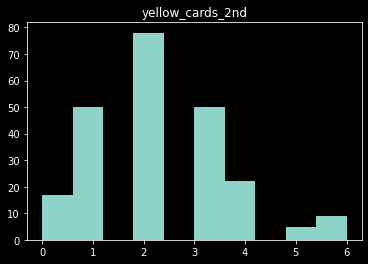

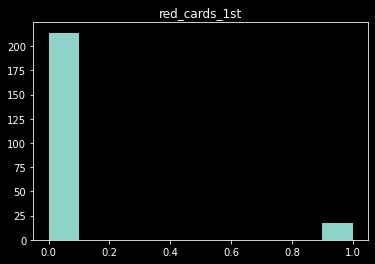

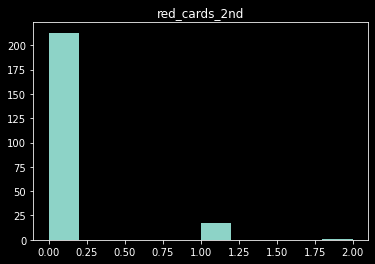

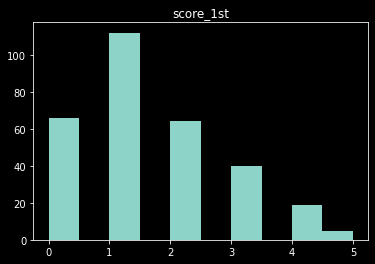

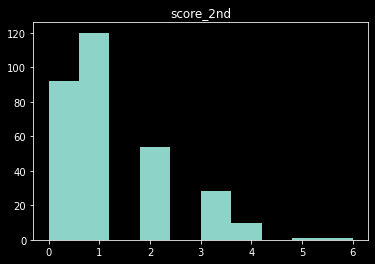

In [8]:
import matplotlib.pyplot as plt

for col_name in numeric_cols:
    plt.hist(data[col_name].dropna().astype(int))
    plt.title(col_name)
    plt.show()
    

### Does Goals follow Poission distribution?

## Examples of density plots of Poisson distributions:

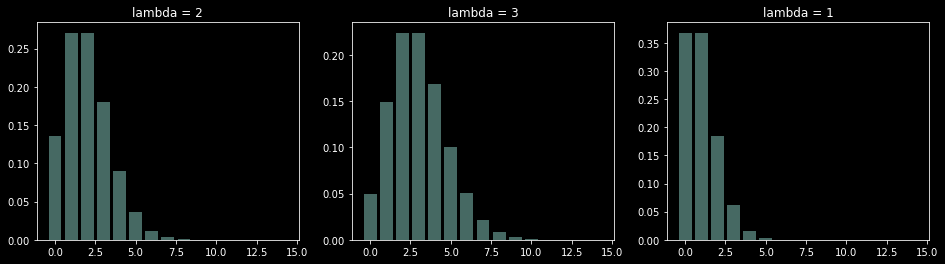

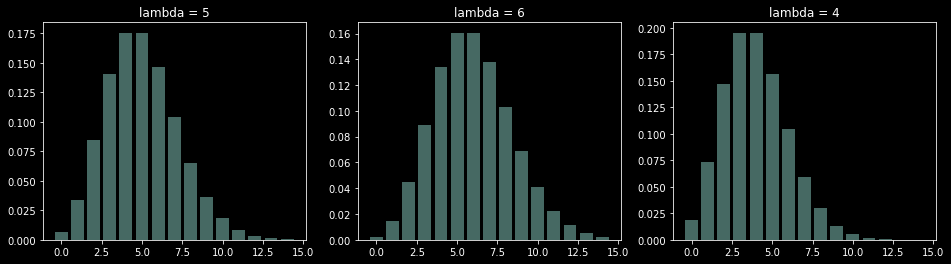

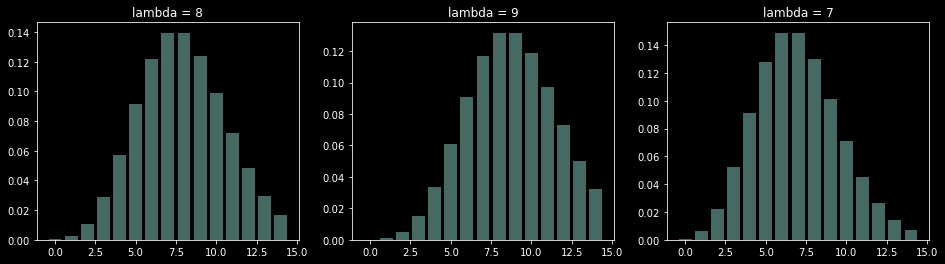

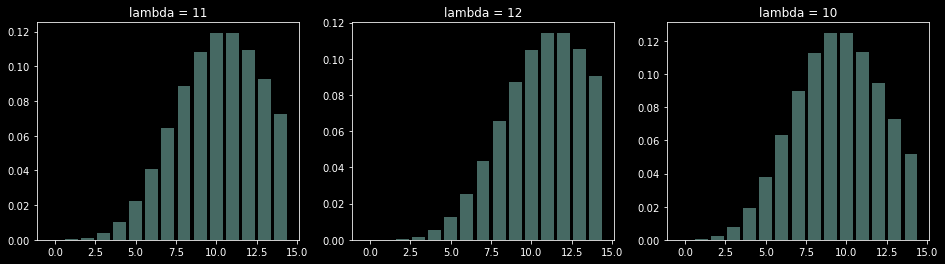

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

for i in range(1, 13):
    if i % 3 == 1: plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, ((i + 1) % 3) + 1 )
    x = np.arange(0, 15)
    plt.bar(x, poisson.pmf(x, i), align='center', alpha=0.5, label='Poisson PMF')
    plt.title(f'lambda = {i}')
    if i % 3 == 0: plt.show()

    

### To check this, i will take 'observed' and 'expected' values from given observations (assuming that it follows Pois distribution) to calculate chi_squared statistic present in test where:
### the null Hypothesis says that the data follows Poisson distribution vs the alternative: it does not .

In [10]:
from scipy.stats import poisson
from typing import List

# the function below split data into bins to calculate chi squared statistic to check consistency with Pois distribution
def buildBinsForPoisson(vals: pd.Series) -> (List[int], List[int]):
    prevent_push = False
    vals = vals.sort_index()
    indices = vals.index
    values = vals.values
    total = np.sum(values)
    no_index = len(indices)
    curr_index = no_index - 1
    estimated_lambda = 0
    for i in indices:
        estimated_lambda += i*vals[i]
    estimated_lambda = estimated_lambda / total
    observed = []
    expected = []
    while(curr_index >= 0):
        expected_value = 0
        observed_value = 0
        while expected_value < 5:
            prob_of_value = 0
            if curr_index == no_index - 1:
                prob_of_value = 1 - poisson.cdf(indices[curr_index] - 1, estimated_lambda)
            else:
                prob_of_value = poisson.pmf(indices[curr_index], estimated_lambda)
                
            expected_value += prob_of_value*total
            observed_value += vals[indices[curr_index]]
            curr_index = curr_index - 1
            if curr_index == -1 and expected_value < 5:
                observed[-1] += observed_value
                expected[-1] += expected_value
                prevent_push = True
                break
                
        if not prevent_push:
            observed.append(observed_value)
            expected.append(expected_value)
    observed.reverse()
    expected.reverse()
    return (observed, expected)

In [11]:
from scipy.stats import poisson
from scipy.stats import chisquare

# testing our function on sample from Poiss
pois_sample = poisson.rvs(3, size=100, random_state=17)
sample_series = pd.Series(pois_sample).value_counts()
(observed, expected) = buildBinsForPoisson(sample_series)
chisquare(observed, expected)


Power_divergenceResult(statistic=0.21505517023764972, pvalue=0.9989432266515322)

### pvalue ~ 0.99 ensures us that the sample is from Poisson distribution (so the function probably works) 

In [12]:
from scipy.stats import chisquare

values = data['score_1st'].value_counts()
(observed, expected) = buildBinsForPoisson(values)
chisquare(observed, expected)


Power_divergenceResult(statistic=4.684798911190217, pvalue=0.4555448464103339)

### Let significance level be 0.05. By receiving pvalue ~ 0.45, there is no basis to reject the null hypothesis saying that 'score_1st' (distribution of goals scored by home teams of all matches) follows Poission distribution. Given that, i say that more probably than not 'score_1st' follows Poission distribution

### I will also check "poissonabality" of some other data variables

In [13]:
def getChiSquareResult(df: pd.DataFrame):
    (obs, exp) = buildBinsForPoisson(df.value_counts())
    return chisquare(obs, exp)

In [14]:
# the lack of data is frequent so we filter by any column which has missing values
data_f = data.copy()[~data['possession_1st'].isna()]

data_f['score_total'] = data_f['score_1st'] + data_f['score_2nd']
data_f['shots_total'] = data_f['shots_1st'] + data_f['shots_2nd']
data_f['shots_on_target_total'] = data['shots_1st'] + data['shots_2nd']
data_f['corners_total'] = data_f['corners_1st'] + data_f['corners_2nd']
data_f['fouls_total'] = data_f['fouls_1st'] + data_f['fouls_2nd']
data_f['passes_total'] = data_f['passes_1st'] + data_f['passes_2nd']
data_f['accurate_passes_total'] = data_f['accurate_passes_1st'] + data_f['accurate_passes_2nd']
data_f['crosses_total'] = data_f['crosses_1st'] + data_f['crosses_2nd']
data_f['accurate_crosses_total'] = data_f['accurate_crosses_1st'] + data_f['accurate_crosses_2nd']
data_f['successful_tackles_total'] = data_f['successful_tackles_1st'] + data_f['successful_tackles_2nd']
data_f['offsides_total'] = data_f['offsides_1st'] + data_f['offsides_2nd']
data_f['yellow_cards_total'] = data['yellow_cards_1st'] + data['yellow_cards_2nd']


In [15]:
cols = ['score_total', 'shots_total', 'shots_on_target_total', 'corners_total', 'fouls_total', 'passes_total', 'accurate_passes_total', 'crosses_total', 'accurate_crosses_total', 'successful_tackles_total', 'offsides_total', 'yellow_cards_total']

print("BEING FROM POISION DISTRIBUTION")
print('-------------------')
for col in cols:
    print('**********')
    print(col, 'p-value: ', getChiSquareResult(data_f[col]).pvalue)

BEING FROM POISION DISTRIBUTION
-------------------
**********
score_total p-value:  0.970859048278362
**********
shots_total p-value:  0.2847312151183011
**********
shots_on_target_total p-value:  0.2847312151183011
**********
corners_total p-value:  0.2078714045031524
**********
fouls_total p-value:  0.2161590755729565
**********
passes_total p-value:  0.0
**********
accurate_passes_total p-value:  0.0
**********
crosses_total p-value:  0.048192094210792714
**********
accurate_crosses_total p-value:  0.583606793298646
**********
successful_tackles_total p-value:  9.560506078433527e-94
**********
offsides_total p-value:  8.618582052424512e-05
**********
yellow_cards_total p-value:  0.3397733874492232


### As we can see above many variables might follow Poisson distribution (by looking at p-value)

### One could check normality of the data, but there are no continuous variables as all of the values are integers 

### Is being a home team has influence on scoring more goals?

In [17]:
from statsmodels.stats.rates import test_poisson_2indep
alt='larger'
nobs = len(data_f)
total1 = data_f['score_1st'].sum()
total2 = data_f['score_2nd'].sum()

test_poisson_2indep(total1, nobs, total2, nobs, alternative=alt)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 2.5417647065265205
pvalue = 0.00551471971536593
distribution = normal
method = score
alternative = larger
rates = (1.5108225108225108, 1.2337662337662338)
ratio = 1.224561403508772
ratio_null = 1
tuple = (2.5417647065265205, 0.00551471971536593)

### If I did the test properly then we can surely reject the null hypothesis in favour of the alternative hypothesis (which means that on average teams score more goals playing in their own stadiums)

### Another question: Is there a correlation between passes / accurate passes and possession?

In [18]:
temp_1st = data[['passes_1st', 'accurate_passes_1st', 'possession_1st']].sort_values(by='possession_1st')
temp_2nd = data[['passes_2nd', 'accurate_passes_2nd', 'possession_2nd']].sort_values(by='possession_2nd')

In [19]:
temp_1st.corr()

,passes_1st,accurate_passes_1st,possession_1st
passes_1st,1.000000,0.986349,0.713246
accurate_passes_1st,0.986349,1.000000,0.722348
possession_1st,0.713246,0.722348,1.000000


In [20]:
temp_1st[temp_1st['passes_1st'] < 100]

,passes_1st,accurate_passes_1st,possession_1st
90,0.0,0.0,61.0


<AxesSubplot:xlabel='possession_1st', ylabel='passes_1st'>

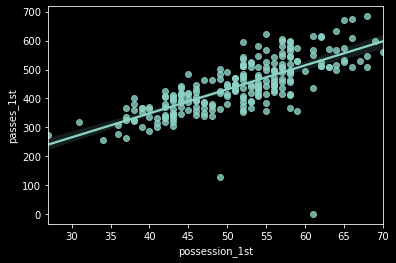

In [21]:
sb.regplot(x=temp_1st['possession_1st'], y=temp_1st['passes_1st'])

### What after removing the biased observation (with passes = 0)?

In [22]:
temp_1st = data[data['passes_1st'] >= 100][['passes_1st', 'accurate_passes_1st', 'possession_1st']].sort_values(by='possession_1st')

In [23]:
temp_1st.corr()

,passes_1st,accurate_passes_1st,possession_1st
passes_1st,1.000000,0.987071,0.778617
accurate_passes_1st,0.987071,1.000000,0.769868
possession_1st,0.778617,0.769868,1.000000


<AxesSubplot:xlabel='possession_1st', ylabel='passes_1st'>

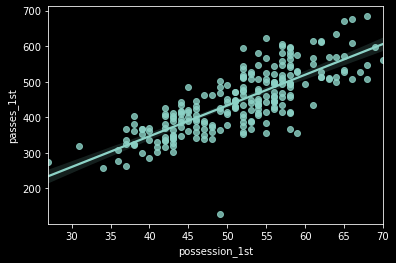

In [24]:
sb.regplot(x=temp_1st['possession_1st'], y=temp_1st['passes_1st'])

### Knowing passes one could try to predict possession with the use, for example, linear regression (because the relationship seems to be linear with a little bias)

### That for '1st', will it be the same for '2nd'?

In [26]:
temp_2nd.corr()

,passes_2nd,accurate_passes_2nd,possession_2nd
passes_2nd,1.000000,0.987062,0.818510
accurate_passes_2nd,0.987062,1.000000,0.802519
possession_2nd,0.818510,0.802519,1.000000


<AxesSubplot:xlabel='possession_2nd', ylabel='passes_2nd'>

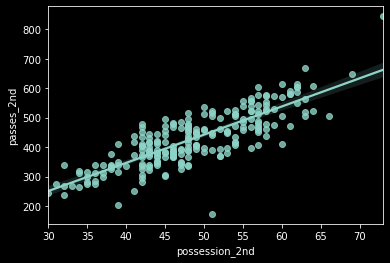

In [27]:
sb.regplot(x=temp_2nd['possession_2nd'], y=temp_2nd['passes_2nd'])

### The linearity seems to be even greater

### Okay but maybe there are more correlations between variables?

In [28]:
columns_1st = filter(lambda x: x.__contains__('1st'), list(data.columns))
columns_2nd = filter(lambda x: x.__contains__('2nd'), list(data.columns))

data_1st = data[list(columns_1st)]
data_2nd = data[list(columns_2nd)]

In [29]:
data_1st.corr()

,possession_1st,shots_1st,shots_on_target_1st,corners_1st,passes_1st,accurate_passes_1st,crosses_1st,accurate_crosses_1st,successful_tackles_1st,fouls_1st,offsides_1st,yellow_cards_1st,red_cards_1st,score_1st
possession_1st,1.000000,0.356154,0.109424,0.333337,0.713246,0.722348,0.494380,0.331571,-0.081057,-0.068678,-0.037422,-0.079892,-0.064851,-0.017279
shots_1st,0.356154,1.000000,0.694669,0.500068,0.247604,0.255162,0.447249,0.417219,-0.103906,-0.040479,0.057849,-0.023378,-0.030734,0.308265
shots_on_target_1st,0.109424,0.694669,1.000000,0.316063,0.095289,0.116998,0.088542,0.230120,0.012706,-0.061533,0.087963,-0.021692,-0.046301,0.604973
corners_1st,0.333337,0.500068,0.316063,1.000000,0.209656,0.205829,0.560776,0.318815,-0.111282,-0.111393,-0.017860,-0.061401,-0.021912,0.033599
passes_1st,0.713246,0.247604,0.095289,0.209656,1.000000,0.986349,0.301531,0.205041,0.216823,-0.046764,-0.049333,-0.130799,-0.055733,-0.068533
accurate_passes_1st,0.722348,0.255162,0.116998,0.205829,0.986349,1.000000,0.311929,0.225292,0.209788,-0.048587,-0.059525,-0.141462,-0.048316,-0.032182
crosses_1st,0.494380,0.447249,0.088542,0.560776,0.301531,0.311929,1.000000,0.613803,-0.121619,0.159853,0.006224,-0.096176,-0.039490,-0.196905
accurate_crosses_1st,0.331571,0.417219,0.230120,0.318815,0.205041,0.225292,0.613803,1.000000,0.044120,0.076129,-0.033565,-0.022704,-0.120740,-0.131177
successful_tackles_1st,-0.081057,-0.103906,0.012706,-0.111282,0.216823,0.209788,-0.121619,0.044120,1.000000,0.120661,0.016949,-0.070139,0.008791,0.020174
fouls_1st,-0.068678,-0.040479,-0.061533,-0.111393,-0.046764,-0.048587,0.159853,0.076129,0.120661,1.000000,0.013268,0.295987,0.062034,-0.094969


### There might be observed a little corr between:
- crosses / corners - 0.56
- crosses / shots = 0.44
- crosses / accurate_crosses - 0.61
- corners / shots - 0.5  
- shots_on_target / shots - 0.69
- accurate_crosses / shots - 0.41
- possession / crosses - 0.49

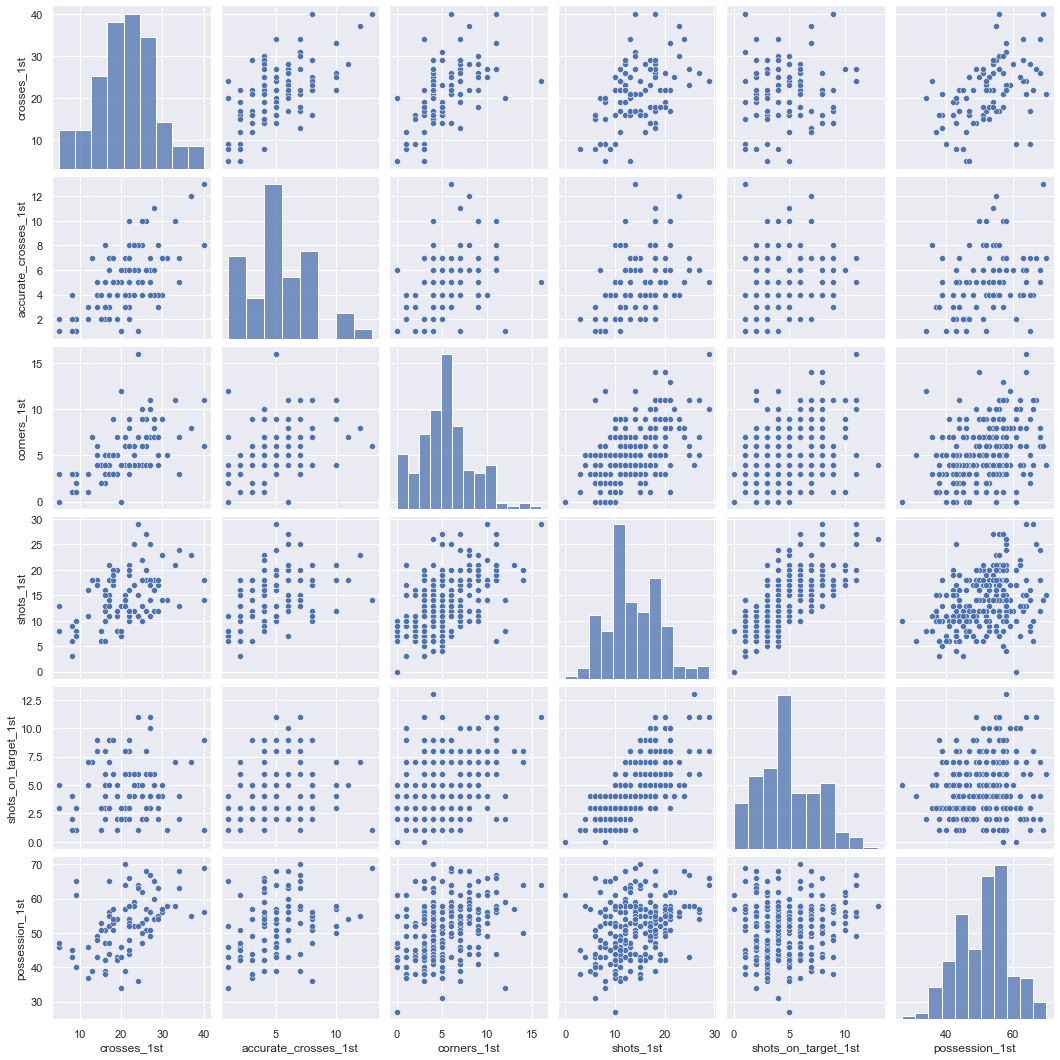

In [30]:
sb.set()
cols = ['crosses_1st', 'accurate_crosses_1st', 'corners_1st', 'shots_1st', 'shots_on_target_1st', 'possession_1st']
sb.pairplot(data_1st[cols], height = 2.5)
plt.show();

### These correlations are not as great as corr between passess and possession

### One more matter: Is there a connection between some of the statistics from the match and place at the end of the season? 

In [31]:
teams = list(data['team_1st'].value_counts().index)
teams.sort()

In [32]:
teams

['BRUK-BET TERMALICA NIECIECZA',
 'CRACOVIA',
 'GÓRNIK ZABRZE',
 'GÓRNIK ŁĘCZNA',
 'JAGIELLONIA BIAŁYSTOK',
 'KGHM ZAGŁĘBIE LUBIN',
 'LECH POZNAŃ',
 'LECHIA GDAŃSK',
 'LEGIA WARSZAWA',
 'PGE FKS STAL MIELEC',
 'PIAST GLIWICE',
 'POGOŃ SZCZECIN',
 'RADOMIAK RADOM',
 'RAKÓW CZĘSTOCHOWA',
 'WARTA POZNAŃ',
 'WISŁA KRAKÓW',
 'WISŁA PŁOCK',
 'ŚLĄSK WROCŁAW']

In [33]:
# places at the end of the season (2021 / 2022)
places = [16, 9, 8, 18, 12, 13, 1, 4, 10, 14, 5, 3, 7, 2, 11, 17, 6, 15]

In [34]:
teams_places = pd.DataFrame({'team': teams, 'place': places}).sort_values(by='place').reset_index().drop(columns='index')

In [35]:
teams_places

,team,place
0,LECH POZNAŃ,1
1,RAKÓW CZĘSTOCHOWA,2
2,POGOŃ SZCZECIN,3
3,LECHIA GDAŃSK,4
4,PIAST GLIWICE,5
5,WISŁA PŁOCK,6
6,RADOMIAK RADOM,7
7,GÓRNIK ZABRZE,8
8,CRACOVIA,9
9,LEGIA WARSZAWA,10


In [36]:
def removePostfix(s: str):
    return s[:-4]

In [37]:
removePostfix('a_1st')

'a'

In [38]:
# To check the data for particular team i have to reshape the data using data_1st and data_2nd

data_1st_renamed = data_1st.rename(removePostfix, axis='columns')
data_2nd_renamed = data_2nd.rename(removePostfix, axis='columns')

data_1st_renamed['is_home'] = 1
data_2nd_renamed['is_home'] = 0
 
data_changed = pd.concat([data_1st_renamed, data_2nd_renamed])

In [39]:
data_changed_mean = data_changed.groupby('team').mean()

In [40]:
display(HTML(scrollable_dataframe(data_changed_mean.head())))

,possession,shots,shots_on_target,corners,passes,accurate_passes,crosses,accurate_crosses,successful_tackles,fouls,offsides,yellow_cards,red_cards,score,is_home
team,,,,,,,,,,,,,,,
BRUK-BET TERMALICA NIECIECZA,50.964286,12.714286,3.642857,4.678571,423.500000,333.678571,22.4,5.8,13.392857,12.857143,2.000000,2.464286,0.035714,1.058824,0.5
CRACOVIA,47.875000,13.333333,4.250000,4.958333,396.083333,301.041667,19.2,4.4,16.250000,15.708333,2.375000,2.083333,0.083333,1.205882,0.5
GÓRNIK ZABRZE,51.259259,13.777778,5.074074,5.555556,474.185185,376.074074,17.2,4.1,14.148148,13.074074,1.777778,1.888889,0.037037,1.617647,0.5
GÓRNIK ŁĘCZNA,44.750000,8.666667,3.291667,4.333333,380.666667,292.750000,20.6,4.3,14.875000,12.833333,1.500000,2.083333,0.166667,0.852941,0.5
JAGIELLONIA BIAŁYSTOK,47.846154,12.038462,4.269231,5.038462,423.500000,334.615385,18.4,4.1,14.923077,14.192308,2.038462,2.653846,0.076923,1.147059,0.5


### For each column i will number rows from the highest value order to the lowest

In [41]:
cols = list(data_changed.columns)
cols.remove('team')
cols.remove('is_home')

length = len(data_changed_mean)

for col in cols:
    data_changed_mean = data_changed_mean.sort_values(by=col, ascending=False)
    data_changed_mean[f'{col}_order'] = range(1, length + 1)

In [42]:
data_joined = data_changed_mean.join(teams_places.set_index('team'), on='team').sort_values(by='place').reset_index()

In [43]:
order_cols = list(filter(lambda x: x.__contains__('_order') ,list(data_joined.columns)))

### To measure how good team was, i think statistics about cards, offsides, fouls and tackles do not tell anything about strength of a team

In [44]:
order_cols.remove('red_cards_order')
order_cols.remove('yellow_cards_order')
order_cols.remove('fouls_order')
order_cols.remove('successful_tackles_order')
order_cols.remove('offsides_order')

In [45]:
data_joined['orders_mean'] = data_joined[order_cols].mean(axis=1)
data_joined['orders_median'] = data_joined[order_cols].median(axis=1)

In [46]:
display(HTML(scrollable_dataframe(data_joined[['team', 'place', 'orders_mean', 'orders_median']])))


,team,place,orders_mean,orders_median
0,LECH POZNAŃ,1,1.666667,1.0
1,RAKÓW CZĘSTOCHOWA,2,5.333333,4.0
2,POGOŃ SZCZECIN,3,3.111111,3.0
3,LECHIA GDAŃSK,4,7.444444,5.0
4,PIAST GLIWICE,5,11.555556,13.0
5,WISŁA PŁOCK,6,11.222222,10.0
6,RADOMIAK RADOM,7,10.222222,10.0
7,GÓRNIK ZABRZE,8,7.000000,5.0
8,CRACOVIA,9,11.000000,12.0
9,LEGIA WARSZAWA,10,5.555556,5.0


### If order_mean would classify place at the end of the season the ranking would look like below

In [47]:
display(HTML(scrollable_dataframe(data_joined[['team', 'place', 'orders_mean']].sort_values(by='orders_mean'))))

,team,place,orders_mean
0,LECH POZNAŃ,1,1.666667
2,POGOŃ SZCZECIN,3,3.111111
1,RAKÓW CZĘSTOCHOWA,2,5.333333
9,LEGIA WARSZAWA,10,5.555556
7,GÓRNIK ZABRZE,8,7.000000
3,LECHIA GDAŃSK,4,7.444444
12,KGHM ZAGŁĘBIE LUBIN,13,8.444444
14,ŚLĄSK WROCŁAW,15,9.000000
15,BRUK-BET TERMALICA NIECIECZA,16,10.222222
6,RADOMIAK RADOM,7,10.222222


### The top 3 is almost properly predicted but some of the teams despite having relatively good "orders_mean" at the end of the season was placed much worse (e.g. Legia Warszawa, Zagłębie Lubin, Śląsk Wrocław)

### If order_median would classify place at the end of the season the ranking would look like below

In [48]:
display(HTML(scrollable_dataframe(data_joined[['team', 'place', 'orders_median']].sort_values(by='orders_median'))))

,team,place,orders_median
0,LECH POZNAŃ,1,1.0
2,POGOŃ SZCZECIN,3,3.0
1,RAKÓW CZĘSTOCHOWA,2,4.0
3,LECHIA GDAŃSK,4,5.0
7,GÓRNIK ZABRZE,8,5.0
9,LEGIA WARSZAWA,10,5.0
14,ŚLĄSK WROCŁAW,15,9.0
12,KGHM ZAGŁĘBIE LUBIN,13,9.0
5,WISŁA PŁOCK,6,10.0
6,RADOMIAK RADOM,7,10.0


### As for median, the first fourth places are almost properly predicted

### Can we select such orders variables which will minize error of differences between "orders_mean" / "orders_median" and actual place? 

In [49]:
error_mean = np.abs(data_joined['orders_mean'] - data_joined['place']).sum()
error_median = np.abs(data_joined['orders_median'] - data_joined['place']).sum()
print(f' Sum of errros for mean: {error_mean}')
print(f' Sum of errros for median: {error_median}')

 Sum of errros for mean: 62.888888888888886
 Sum of errros for median: 58.0


### At first I will look at mean
### I will iteratively remove each column, calculate "orders_mean" and check whether error decreases. If so, then i will remove the column and do iretation again with new columns.
### It will be calculated until error stop decreasing.

In [50]:
mean_cols = np.array(order_cols)

min_error = error_mean
min_error_col_name = ''

new_cols = mean_cols

while True:
    min_error_col_name = ''
    print(f"Start of iteration through columns. Current error is {min_error}")
    temp_cols = np.array(new_cols)
    for col_name in new_cols:
        temp_cols = [x for x in new_cols if x != col_name]
        data_joined['orders_mean_temp'] = data_joined[temp_cols].mean(axis=1)
        curr_error_mean = np.abs(data_joined['orders_mean_temp'] - data_joined['place']).sum()

        if curr_error_mean <= min_error:
            min_error = curr_error_mean
            min_error_col_name = col_name
    if min_error_col_name == '' or len(new_cols) == 1:
        break
    new_cols = [x for x in new_cols if x != min_error_col_name]
    print(f"End if iteration. New error is {min_error} and column to remove is {min_error_col_name}")
    
print("END OF EVERYTHING, THE BEST COLUMNS SEEMS TO BE:")
print(new_cols)

Start of iteration through columns. Current error is 62.888888888888886
End if iteration. New error is 60.25 and column to remove is accurate_crosses_order
Start of iteration through columns. Current error is 60.25
End if iteration. New error is 57.14285714285714 and column to remove is crosses_order
Start of iteration through columns. Current error is 57.14285714285714
End if iteration. New error is 54.0 and column to remove is passes_order
Start of iteration through columns. Current error is 54.0
End if iteration. New error is 50.00000000000001 and column to remove is accurate_passes_order
Start of iteration through columns. Current error is 50.00000000000001
End if iteration. New error is 46.5 and column to remove is possession_order
Start of iteration through columns. Current error is 46.5
End if iteration. New error is 42.0 and column to remove is corners_order
Start of iteration through columns. Current error is 42.0
End if iteration. New error is 38.0 and column to remove is sho

### Really? Only scoring goals? I will run it again but now I will round 'orders_mean' which I should do at the beginning

In [51]:
mean_cols = np.array(order_cols)

min_error = error_mean
min_error_col_name = ''

new_cols = mean_cols

while True:
    min_error_col_name = ''
    print(f"Start of iteration through columns. Current error is {min_error}")
    temp_cols = np.array(new_cols)
    for col_name in new_cols:
        temp_cols = [x for x in new_cols if x != col_name]
        data_joined['orders_mean_temp'] = np.round(data_joined[temp_cols].mean(axis=1))
        curr_error_mean = np.abs(data_joined['orders_mean_temp'] - data_joined['place']).sum()

        if curr_error_mean <= min_error:
            min_error = curr_error_mean
            min_error_col_name = col_name
    if min_error_col_name == '' or len(new_cols) == 1:
        break
    new_cols = [x for x in new_cols if x != min_error_col_name]
    print(f"End if iteration. New error is {min_error} and column to remove is {min_error_col_name}")
    
print("END OF EVERYTHING, THE BEST COLUMNS SEEMS TO BE:")
print(new_cols)

Start of iteration through columns. Current error is 62.888888888888886
End if iteration. New error is 60.0 and column to remove is crosses_order
Start of iteration through columns. Current error is 60.0
End if iteration. New error is 58.0 and column to remove is accurate_crosses_order
Start of iteration through columns. Current error is 58.0
End if iteration. New error is 55.0 and column to remove is accurate_passes_order
Start of iteration through columns. Current error is 55.0
End if iteration. New error is 49.0 and column to remove is passes_order
Start of iteration through columns. Current error is 49.0
End if iteration. New error is 47.0 and column to remove is corners_order
Start of iteration through columns. Current error is 47.0
End if iteration. New error is 41.0 and column to remove is possession_order
Start of iteration through columns. Current error is 41.0
End if iteration. New error is 35.0 and column to remove is shots_order
Start of iteration through columns. Current e

### Now we have two columns which minimize our simple error metric :)

### Now let's look at median

In [52]:
median_cols = np.array(order_cols)

min_error = error_median
min_error_col_name = ''

new_cols = mean_cols

while True:
    min_error_col_name = ''
    print(f"Start of iteration through columns. Current error is {min_error}")
    temp_cols = np.array(new_cols)
    for col_name in new_cols:
        temp_cols = [x for x in new_cols if x != col_name]
        data_joined['orders_median_temp'] = np.round(data_joined[temp_cols].median(axis=1))
        curr_error_mean = np.abs(data_joined['orders_median_temp'] - data_joined['place']).sum()

        if curr_error_mean <= min_error:
            min_error = curr_error_mean
            min_error_col_name = col_name
    if min_error_col_name == '' or len(new_cols) == 1:
        break
    new_cols = [x for x in new_cols if x != min_error_col_name]
    print(f"End if iteration. New error is {min_error} and column to remove is {min_error_col_name}")
    
print("END OF EVERYTHING, THE BEST COLUMNS SEEMS TO BE:")
print(new_cols)

Start of iteration through columns. Current error is 58.0
End if iteration. New error is 54.0 and column to remove is corners_order
Start of iteration through columns. Current error is 54.0
End if iteration. New error is 51.0 and column to remove is possession_order
Start of iteration through columns. Current error is 51.0
End if iteration. New error is 50.0 and column to remove is accurate_crosses_order
Start of iteration through columns. Current error is 50.0
End if iteration. New error is 47.0 and column to remove is passes_order
Start of iteration through columns. Current error is 47.0
End if iteration. New error is 41.0 and column to remove is crosses_order
Start of iteration through columns. Current error is 41.0
End if iteration. New error is 39.0 and column to remove is accurate_passes_order
Start of iteration through columns. Current error is 39.0
End if iteration. New error is 35.0 and column to remove is shots_order
Start of iteration through columns. Current error is 35.0
E

### For median the error is a little bit smaller and the columns are the same which minimizes error.  
### Let's draw the winning predictor

In [53]:
data_joined['orders_mean_ubg'] = data_joined[['shots_on_target_order', 'score_order']].mean(axis=1)
data_joined['orders_median_ubg'] = data_joined[['shots_on_target_order', 'score_order']].median(axis=1)

### Median predictor:

In [54]:
display(HTML(scrollable_dataframe(data_joined[['team', 'place', 'orders_median_ubg']].sort_values(by='orders_median_ubg'))))

,team,place,orders_median_ubg
0,LECH POZNAŃ,1,1.0
1,RAKÓW CZĘSTOCHOWA,2,2.5
2,POGOŃ SZCZECIN,3,2.5
7,GÓRNIK ZABRZE,8,4.0
3,LECHIA GDAŃSK,4,5.0
14,ŚLĄSK WROCŁAW,15,8.0
5,WISŁA PŁOCK,6,9.0
6,RADOMIAK RADOM,7,9.0
9,LEGIA WARSZAWA,10,9.5
12,KGHM ZAGŁĘBIE LUBIN,13,9.5


### Piast Gliwice and Cracovia are unfortunately placed really low (By the orders_mean)

### Mean predictor:

In [55]:
display(HTML(scrollable_dataframe(data_joined[['team', 'place', 'orders_mean_ubg']].sort_values(by='orders_mean_ubg'))))

,team,place,orders_mean_ubg
0,LECH POZNAŃ,1,1.0
1,RAKÓW CZĘSTOCHOWA,2,2.5
2,POGOŃ SZCZECIN,3,2.5
7,GÓRNIK ZABRZE,8,4.0
3,LECHIA GDAŃSK,4,5.0
14,ŚLĄSK WROCŁAW,15,8.0
5,WISŁA PŁOCK,6,9.0
6,RADOMIAK RADOM,7,9.0
9,LEGIA WARSZAWA,10,9.5
12,KGHM ZAGŁĘBIE LUBIN,13,9.5


### Am I missing something or MEDIAN and MEAN give the same scores?

### There is also one thing that could predict places really well: it is scored goals divided by lost goals

In [67]:
# I will use earlier created columns_1st

data_1 = data[['team_1st', 'score_1st', 'score_2nd']]
data_2 = data[['team_2nd', 'score_1st', 'score_2nd']]

data_1_renamed = data_1.rename(columns={'team_1st': 'team', 'score_1st': 'score', 'score_2nd': 'score_loss'})
data_2_renamed = data_2.rename(columns={'team_2nd': 'team', 'score_2nd': 'score', 'score_1st': 'score_loss'})
 
data_changed = pd.concat([data_1_renamed, data_2_renamed])

In [68]:
data_changed_mean = data_changed.groupby('team').mean()
data_changed_mean['score_ratio'] = data_changed_mean['score'] / data_changed_mean['score_loss']

In [69]:
data_joined = data_changed_mean.join(teams_places.set_index('team'), on='team').sort_values(by='place').reset_index()

In [70]:
display(HTML(scrollable_dataframe(data_joined)))

,team,score,score_loss,score_ratio,place
0,LECH POZNAŃ,1.970588,0.705882,2.791667,1
1,RAKÓW CZĘSTOCHOWA,1.764706,0.882353,2.000000,2
2,POGOŃ SZCZECIN,1.852941,0.911765,2.032258,3
3,LECHIA GDAŃSK,1.529412,1.147059,1.333333,4
4,PIAST GLIWICE,1.352941,1.088235,1.243243,5
5,WISŁA PŁOCK,1.411765,1.500000,0.941176,6
6,RADOMIAK RADOM,1.235294,1.205882,1.024390,7
7,GÓRNIK ZABRZE,1.617647,1.617647,1.000000,8
8,CRACOVIA,1.205882,1.264706,0.953488,9
9,LEGIA WARSZAWA,1.352941,1.411765,0.958333,10


### It is easy to see that higher score_ratio implies better place.
### It isn't suprising, It is rather obvious that it should be like that.